# Experimentos, graficación e implementación de los algoritmos
# $f(x,y)=4(x + y + xy)^2 + x^4$



## Importaciones y carpetas

Guardamos resultados en `./data` y figuras en `./figs` (rutas relativas al cuaderno).

In [1]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm


# Carpetas locales (junto al .ipynb)
DATA_DIR = "./data"
FIG_DIR  = "./figs"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

## Definición de $f, \nabla f, H$

In [2]:
def f(x, y):
    return 4*(x + y + x*y)**2 + x**4

def grad(x, y):
    return np.array([
        8*(x + y + x*y)*(1 + y) + 4*x**3,
        8*(x + y + x*y)*(1 + x)
    ], dtype=float)

def hess(x, y):
    return np.array([
        [8*(1 + y)**2 + 12*x**2, 8*(1 + x)*(1 + y) + 8*(x + y + x*y)],
        [8*(1 + x)*(1 + y) + 8*(x + y + x*y), 8*(1 + x)**2]
    ], dtype=float)


## Visualización en 3D de el modelo

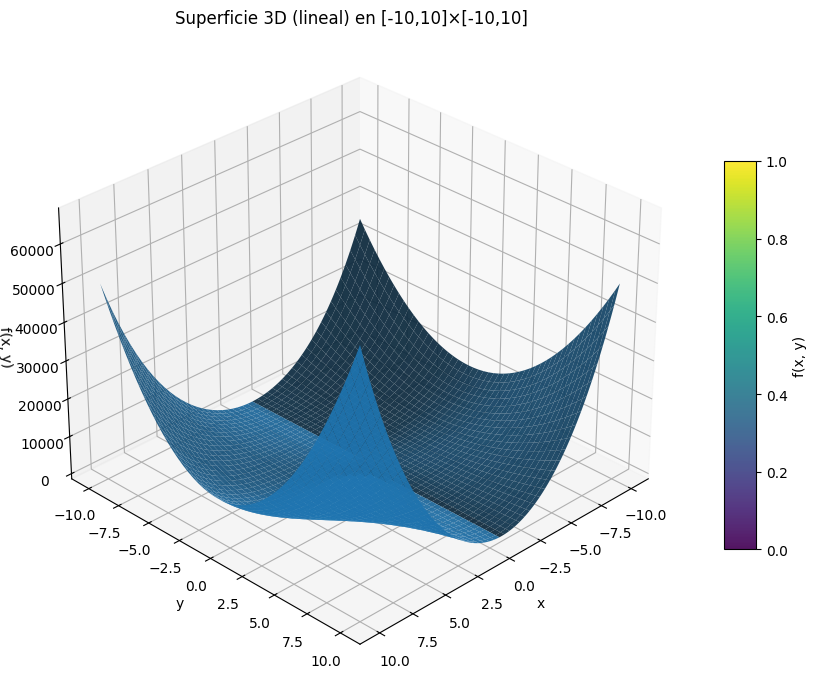

'./figs/f_surface_linear_[-10,10].png'

In [3]:
def plot_function_3d(x_min, x_max, y_min, y_max, n=200,
                     elev=30, azim=45,
                     filename=None, show=True):
    xs = np.linspace(x_min, x_max, n)
    ys = np.linspace(y_min, y_max, n)
    X, Y = np.meshgrid(xs, ys)
    Z = f(X, Y)
    zlabel = "f(x, y)"
    title = f"Superficie 3D (lineal) en [{x_min},{x_max}]×[{y_min},{y_max}]"

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, edgecolor='none', alpha=0.92)
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12, label=zlabel)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(zlabel)
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=180)
    if show:
        plt.show()
    else:
        plt.close(fig)
    return filename

plot_function_3d(x_min=-10, x_max=10, y_min=-10, y_max=10,
                 filename=f"./figs/f_surface_linear_[-10,10].png", show=True)



## Implementación del método de backtracking con condición de Armijo

In [4]:
def armijo_backtracking(xy, d, fval, grad_xy, alpha0=1.0, rho=0.5, c=1e-4, max_bt=30):
    x, y = xy
    gTd = grad_xy @ d
    alpha = alpha0
    for _ in range(max_bt):
        xn, yn = x + alpha*d[0], y + alpha*d[1]
        fn = f(xn, yn)
        if fn <= fval + c*alpha*gTd:
            return alpha, fn, np.array([xn, yn])
        alpha *= rho
    return 0.0, fval, np.array([x, y])

## Algoritmos: descenso por gradiente y Newton amortiguado

In [5]:
def gd_with_linesearch(xy0, tol=1e-8, maxit=3000, alpha0=1.0):
    path = [np.array(xy0, dtype=float)]
    fvals = [f(*xy0)]
    alphas = []  
    
    for k in range(maxit):
        x, y = path[-1]
        g = grad(x, y)
        gn = np.linalg.norm(g)
        if gn < tol:
            return {"name":"GD", "success":True, "k":k, "xy":(x,y), "f":fvals[-1],
                    "grad_norm":gn, "path":np.array(path), "fvals":np.array(fvals),
                    "alphas": alphas}  
        
        d = -g
        alpha, fn, xnyn = armijo_backtracking(np.array([x,y]), d, fvals[-1], g, alpha0=alpha0)
        alphas.append(alpha)  
        
        if alpha == 0.0:
            return {"name":"GD", "success":False, "k":k, "xy":(x,y), "f":fvals[-1],
                    "grad_norm":gn, "path":np.array(path), "fvals":np.array(fvals),
                    "reason":"no_step", "alphas": alphas}  
        
        path.append(xnyn)
        fvals.append(fn)
    
    return {"name":"GD", "success":False, "k":maxit, "xy":tuple(path[-1]), "f":fvals[-1],
            "grad_norm":np.linalg.norm(grad(*path[-1])), "path":np.array(path),
            "fvals":np.array(fvals), "reason":"maxit", "alphas": alphas}  

def newton_damped(xy0, tol=1e-8, maxit=1000, lambda0=1e-4, alpha0=1.0):
    path = [np.array(xy0, dtype=float)]
    fvals = [f(*xy0)]
    lam = lambda0
    alphas = []  
    lambdas = [] 
    
    for k in range(maxit):
        x, y = path[-1]
        g = grad(x, y)
        gn = np.linalg.norm(g)
        lambdas.append(lam)  
        
        if gn < tol:
            return {"name":"NewtonD", "success":True, "k":k, "xy":(x,y), "f":fvals[-1],
                    "grad_norm":gn, "path":np.array(path), "fvals":np.array(fvals),
                    "lambda":lam, "alphas": alphas, "lambdas": lambdas}  
        
        H = hess(x, y) + lam*np.eye(2)
        try:
            d = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            return {"name":"NewtonD", "success":False, "k":k, "xy":(x,y), "f":fvals[-1],
                    "grad_norm":gn, "path":np.array(path), "fvals":np.array(fvals),
                    "lambda":lam, "reason":"singular", "alphas": alphas, "lambdas": lambdas} 
        
        alpha, fn, xnyn = armijo_backtracking(np.array([x,y]), d, fvals[-1], g, alpha0=alpha0)
        alphas.append(alpha)  
        
        if alpha == 0.0:
            lam *= 10.0
            continue
        
        path.append(xnyn)
        fvals.append(fn)
        lam = max(lambda0, lam/2.0)
    
    return {"name":"NewtonD", "success":False, "k":maxit, "xy":tuple(path[-1]), "f":fvals[-1],
            "grad_norm":np.linalg.norm(grad(*path[-1])), "path":np.array(path),
            "fvals":np.array(fvals), "lambda":lam, "reason":"maxit", "alphas": alphas, "lambdas": lambdas}  

## Experimentos

In [6]:
def run_suite(N=400, a=100.0, tol=1e-8,
              gd_params=dict(tol=1e-8, maxit=3000, alpha0=1.0),
              nd_params=dict(tol=1e-8, maxit=1000, lambda0=1e-4, alpha0=1.0),
              save_paths=True,          
              downsample=None,          
              data_dir="./data"):
    os.makedirs(data_dir, exist_ok=True)
    paths_dir = os.path.join(data_dir, f"paths_N{N}")
    if save_paths:
        os.makedirs(paths_dir, exist_ok=True)

    rng = np.random.default_rng(12345)
    starts = rng.uniform(-a, a, size=(N,2))
    records = []

    def _pack_and_save(case_idx, res_gd, res_nd):
        """Guarda paths/alphas/lambdas comprimidos en .npz y devuelve ruta relativa."""
        if not save_paths:
            return None
        def _maybe_ds(arr):
            if arr is None: return None
            arr = np.asarray(arr)
            if downsample and downsample > 1 and arr.shape[0] > downsample:
                return arr[::downsample]
            return arr

        gd_path  = _maybe_ds(res_gd.get("path", None))
        nd_path  = _maybe_ds(res_nd.get("path", None))
        gd_a     = _maybe_ds(res_gd.get("alphas", None))
        nd_a     = _maybe_ds(res_nd.get("alphas", None))
        nd_l     = _maybe_ds(res_nd.get("lambdas", None))

        out_npz = os.path.join(paths_dir, f"case_{case_idx:04d}.npz")
        np.savez_compressed(out_npz,
                            gd_path=gd_path,
                            newton_path=nd_path,
                            gd_alphas=gd_a,
                            newton_alphas=nd_a,
                            newton_lambdas=nd_l)
        return os.path.relpath(out_npz, start=data_dir)

    def summarize(res, start_point):
        if "path" in res and len(res["path"]) > 0:
            path = np.asarray(res["path"])
            diffs = np.diff(path, axis=0) if len(path) > 1 else np.zeros((0,2))
            path_len = float(np.sum(np.linalg.norm(diffs, axis=1)))
            max_abs  = float(np.max(np.abs(path)))
            end      = path[-1]
            val      = float(res["f"])
        else:
            path_len = 0.0
            max_abs  = float(np.max(np.abs(start_point)))
            end      = np.array(start_point)
            val      = float(res["f"])

        cat = "other"
        if np.linalg.norm(end) < 5.0 and val < 1e-6:
            cat = "origin_near"
        elif val > 1e6:
            cat = "high_value"
        elif np.linalg.norm(end) > 50:
            cat = "diverged"

        return dict(
            name=res["name"],
            success=bool(res.get("success", False)),
            k=int(res.get("k", 0)),
            f=val,
            grad_norm=float(res.get("grad_norm", np.nan)),
            path_len=path_len,
            max_abs=max_abs,
            end_x=float(end[0]),
            end_y=float(end[1]),
            category=cat,
            reason=res.get("reason", ""),
            lam=float(res.get("lambda", np.nan)),
        )

    for i, (x0, y0) in enumerate(starts):
        r_gd = gd_with_linesearch((x0, y0), **gd_params)
        r_nd = newton_damped((x0, y0), **nd_params)

        paths_rel = _pack_and_save(i, r_gd, r_nd)

        rec = dict(
            start=[float(x0), float(y0)],
            gd=summarize(r_gd, [x0, y0]),
            newton=summarize(r_nd, [x0, y0]),
        )
        if save_paths:
            rec["paths_file"] = paths_rel  

        records.append(rec)
        if (i + 1) % 50 == 0:
            print(f"Procesados {i + 1}/{N} puntos...")

    payload = dict(params=dict(N=N, a=a, tol=tol), results=records)

    out_json = os.path.join(data_dir, f"results_N{N}_summary.json") 
    with open(out_json, "w") as fjson:
        json.dump(payload, fjson, indent=2)
    print(f"Guardado resumen: {out_json}")
    if save_paths:
        print(f"Paths comprimidos en: {paths_dir} (downsample={downsample})")

    return payload, out_json

payload, json_path = run_suite(N=400)  
print(f"Archivo generado: {json_path}")


# Helper para cargar trayectorias
def load_paths_for_case(rec, data_dir="./data"):
    """
    Carga las trayectorias (GD/Newton) del .npz referenciado en rec['paths_file'].
    Devuelve dict: {"GD": np.array(N,2), "Newton": np.array(M,2)} + extras.
    """
    if "paths_file" not in rec:
        raise ValueError("Este JSON no referencia 'paths_file'. Ejecuta run_suite(save_paths=True).")
    npz_path = os.path.join(data_dir, rec["paths_file"])
    data = np.load(npz_path, allow_pickle=True)
    out = {
        "GD": data["gd_path"] if "gd_path" in data else None,
        "Newton": data["newton_path"] if "newton_path" in data else None,
        "GD_alphas": data["gd_alphas"] if "gd_alphas" in data else None,
        "Newton_alphas": data["newton_alphas"] if "newton_alphas" in data else None,
        "Newton_lambdas": data["newton_lambdas"] if "newton_lambdas" in data else None,
    }
    return out



Procesados 50/400 puntos...
Procesados 100/400 puntos...
Procesados 150/400 puntos...
Procesados 200/400 puntos...
Procesados 250/400 puntos...
Procesados 300/400 puntos...
Procesados 350/400 puntos...
Procesados 400/400 puntos...
Guardado resumen: ./data/results_N400_summary.json
Paths comprimidos en: ./data/paths_N400 (downsample=None)
Archivo generado: ./data/results_N400_summary.json


## Análisis de resultados y casos críticos

In [7]:
with open(json_path, "r") as fjson:
    data = json.load(fjson)
rows = []
for rec in data["results"]:
    sx, sy = rec["start"]
    for key in ("gd", "newton"):
        r = rec[key]
        rows.append(dict(
            algo=key, start_x=sx, start_y=sy,
            success=r["success"], k=r["k"], f=r["f"], grad_norm=r["grad_norm"],
            path_len=r["path_len"], max_abs=r["max_abs"], end_x=r["end_x"], end_y=r["end_y"],
            category=r["category"], reason=r["reason"], lam=r.get("lam", float('nan'))
        ))
df = pd.DataFrame(rows)

def summary_table(df, algo):
    sub = df[df["algo"]==algo]
    def pct(x): return 100.0*len(x)/len(sub) if len(sub)>0 else np.nan
    tab = {
        "N casos": len(sub),
        "Éxito (%)": 100.0*np.mean(sub["success"]) if len(sub)>0 else np.nan,
        "k mediana": float(np.median(sub["k"])) if len(sub)>0 else np.nan,
        "k [P25, P75]": (float(np.percentile(sub["k"],25)), float(np.percentile(sub["k"],75))) if len(sub)>0 else (np.nan,np.nan),
        "f mediana": float(np.median(sub["f"])) if len(sub)>0 else np.nan,
        "||g|| mediana": float(np.median(sub["grad_norm"])) if len(sub)>0 else np.nan,
        "long. camino mediana": float(np.median(sub["path_len"])) if len(sub)>0 else np.nan,
        "max_abs mediana": float(np.median(sub["max_abs"])) if len(sub)>0 else np.nan,
        "cat origin_near (%)": pct(sub[sub["category"]=="origin_near"]),
        "cat high_value (%)": pct(sub[sub["category"]=="high_value"]),
        "cat diverged (%)": pct(sub[sub["category"]=="diverged"]),
        "fallo no_step/maxit (%)": pct(sub[(~sub["success"]) & (sub["reason"].isin(["no_step","maxit"]))]),
    }
    return pd.Series(tab)

display(summary_table(df, "gd").to_frame("Descenso por gradiente"))
display(summary_table(df, "newton").to_frame("Newton amortiguado"))

,Descenso por gradiente
N casos,400
Éxito (%),0.25
k mediana,3000.0
"k [P25, P75]","(3000.0, 3000.0)"
f mediana,0.552544
||g|| mediana,0.001107
long. camino mediana,155.246879
max_abs mediana,69.607665
cat origin_near (%),44.5
cat high_value (%),0.0


,Newton amortiguado
N casos,400
Éxito (%),66.5
k mediana,58.0
"k [P25, P75]","(49.0, 1000.0)"
f mediana,0.0
||g|| mediana,0.0
long. camino mediana,101.730809
max_abs mediana,85.796393
cat origin_near (%),58.25
cat high_value (%),0.0


## Mapa de contornos 2D (log) con trayectorias

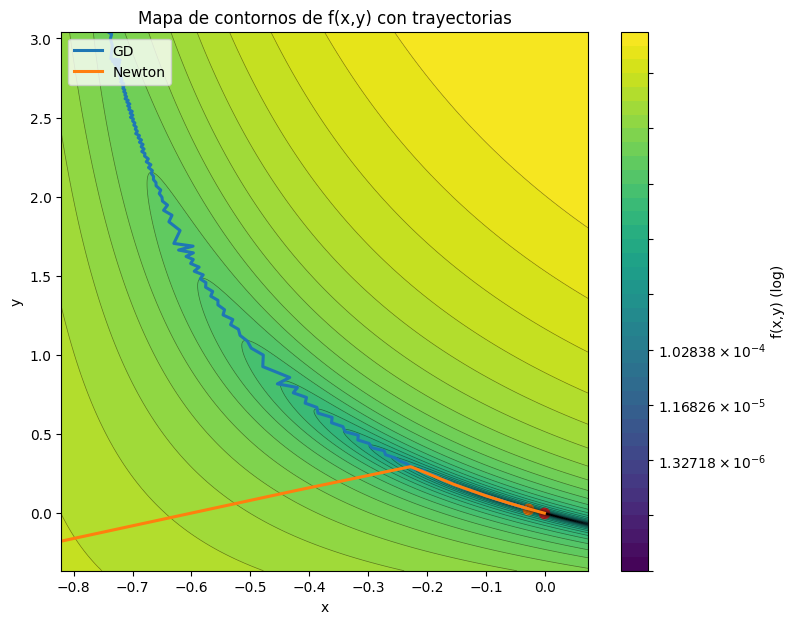

In [8]:
def _to_path_array(traj):
    arr = np.array(traj, dtype=float)
    return arr if arr.ndim == 2 else arr.reshape(-1, 2)

def _pct_bounds(a, p=(5, 95), pad=0.15):
    lo, hi = np.percentile(a, p)
    span = hi - lo if hi > lo else 1.0
    return (lo - pad*span, hi + pad*span)

def contour_with_paths(
    f,
    paths,                 
    xlim=None, ylim=None,
    grid_n=500,
    levels=30,
    use_log_levels=True,   
    fill=True,             
    cmap="viridis",
    clip_pct=99.0,
    save_path=None,        
    dpi=300,               
    show=True              
):
    # --- Normaliza rutas y encuadre
    norm = {name: _to_path_array(traj) for name, traj in paths.items() if len(traj) > 0}
    xs = np.concatenate([a[:,0] for a in norm.values()])
    ys = np.concatenate([a[:,1] for a in norm.values()])
    if xlim is None: xlim = _pct_bounds(xs)
    if ylim is None: ylim = _pct_bounds(ys)

    # --- Malla y f
    x = np.linspace(*xlim, grid_n)
    y = np.linspace(*ylim, grid_n)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    Zclip = np.clip(Z, 0, np.percentile(Z, clip_pct))

    # --- Niveles
    if use_log_levels:
        vmin = max(1e-12, float(np.nanmin(Zclip)))
        vmax = float(np.nanmax(Zclip))
        levels_vals = np.geomspace(vmin, vmax, levels)
        normc = LogNorm(vmin=vmin, vmax=vmax)
        cbar_label = "f(x,y) (log)"
    else:
        levels_vals = np.linspace(float(np.nanmin(Zclip)), float(np.nanmax(Zclip)), levels)
        normc = None
        cbar_label = "f(x,y)"

    # --- Dibujo
    fig, ax = plt.subplots(figsize=(8.5, 7))
    if fill:
        cf = ax.contourf(X, Y, Zclip, levels=levels_vals, norm=normc, cmap=cmap)
        plt.colorbar(cf, ax=ax, label=cbar_label)
    ax.contour(X, Y, Zclip, levels=levels_vals, norm=normc,
               colors="k", linewidths=0.5, alpha=0.45)

    # --- Trayectorias
    for name, arr in norm.items():
        ax.plot(arr[:,0], arr[:,1], linewidth=2.2, label=name)
        ax.scatter(arr[0,0],  arr[0,1],  s=45)   # inicio
        ax.scatter(arr[-1,0], arr[-1,1], s=55)   # fin

    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title("Mapa de contornos de f(x,y) con trayectorias")
    ax.legend(loc="upper left")

    # --- Guardar si se pide
    if save_path is not None:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    if show:
        plt.show()

    return fig, ax



with open("./data/results_N400_summary.json") as fjson:
    payload = json.load(fjson)

rec = payload["results"][0]
paths_data = load_paths_for_case(rec, data_dir="./data")

paths = {
    "GD":     None if paths_data["GD"]     is None else paths_data["GD"][::5],
    "Newton": None if paths_data["Newton"] is None else paths_data["Newton"][::2],
}
paths = {k: v for k, v in paths.items() if v is not None}


fig, ax = contour_with_paths(
    f,
    paths,
    grid_n=1000,
    levels=40,
    clip_pct=98.0,
    save_path="./figs/contours_gd_newton.png", 
    dpi=300
)



## Superficie y trayectoria (3D)

In [9]:
def plot_path_fxy(path,
                  xmin=None, xmax=None, ymin=None, ymax=None,
                  pad=2.0, num=200,
                  elev=30, azim=35,
                  show_tail=250,      
                  kmax=None,          
                  highlight_k=None,  
                  marker_every=1,     
                  lift=0.0,           
                  clip_pct=99.0,     
                  color='crimson',
                  label='GD (α0=1.0)',
                  save_path=None,   
                  dpi=300,
                  show=True):
    """
    Dibuja la superficie z = f(x,y) y la trayectoria 'path' en 3D.
    Supone que existe una función global f(x, y) que acepta arrays de NumPy.
    """

    path = _to_path_array(path)
    if len(path) == 0:
        raise ValueError("La trayectoria está vacía.")

    # --- Recortes temporales de la trayectoria ---
    if kmax is not None:
        kmax = max(0, min(int(kmax), len(path)-1))
        path = path[:kmax+1]
    if show_tail is not None and len(path) > show_tail:
        path = path[-show_tail:]

    # --- Encuadre automático alrededor de la trayectoria ---
    px_min, py_min = path[:, 0].min(), path[:, 1].min()
    px_max, py_max = path[:, 0].max(), path[:, 1].max()
    if xmin is None: xmin = px_min - pad
    if xmax is None: xmax = px_max + pad
    if ymin is None: ymin = py_min - pad
    if ymax is None: ymax = py_max + pad

    # --- Malla de la superficie ---
    xs = np.linspace(xmin, xmax, num)
    ys = np.linspace(ymin, ymax, num)
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    Z = f(X, Y)

    # --- Valores de la trayectoria ---
    Zp = np.array([f(px, py) for px, py in path])

    # --- Rango en z robusto (evita que outliers aplasten el valle) ---
    allZ = np.concatenate([Z.ravel(), Zp])
    clip_pct = float(clip_pct)
    low_q = max(0.0, 1.0 - clip_pct/100.0)  
    high_q = min(1.0, clip_pct/100.0)        
    zlo = np.quantile(allZ, low_q)
    zhi = np.quantile(allZ, high_q)
    zmin, zmax = float(zlo), float(zhi)

    # --- Levanta la curva para que no se esconda en la superficie ---
    if not lift:
        lift = 0.01 * max(1e-9, (zmax - zmin))
    Zp_line = Zp + lift

    # === Plot ===
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Superficie y contornos proyectados al plano z=zmin
    surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True,
                           cmap='viridis', edgecolor='none', alpha=0.85)
    ax.contour(X, Y, Z, zdir='z', offset=zmin, levels=15,
               cmap='viridis', alpha=0.55, linewidths=0.7)

    # Trayectoria
    ax.plot(path[:, 0], path[:, 1], Zp_line, linestyle='--', linewidth=2.2,
            color=color, label=label, zorder=4)

    if marker_every is None or marker_every < 1:
        marker_every = 1
    pts = path[::marker_every]
    zp_pts = Zp_line[::marker_every]
    ax.scatter(pts[:, 0], pts[:, 1], zp_pts, s=20,
               color=color, depthshade=False, zorder=5)

    # Inicio / fin
    ax.scatter(path[0, 0],  path[0, 1],  Zp_line[0],
               s=70, marker='x', color='k', zorder=6)
    ax.scatter(path[-1, 0], path[-1, 1], Zp_line[-1],
               s=70, marker='*', edgecolor='k', color='white', zorder=6)

    # Paso destacado
    if highlight_k is not None:
        hk = max(0, min(int(highlight_k), len(path)-1))
        ax.scatter(path[hk, 0], path[hk, 1], Zp_line[hk],
                   s=90, marker='o', edgecolor='k', color='yellow',
                   zorder=7, label=f'paso {hk}')

    # Ejes, título y colorbar
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x,y)')
    ax.set_title('Superficie y trayectoria')
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.05, label='f(x,y)')
    ax.legend(loc='upper left')
    plt.tight_layout()

    # --- Guardar y/o mostrar ---
    if save_path is not None:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax

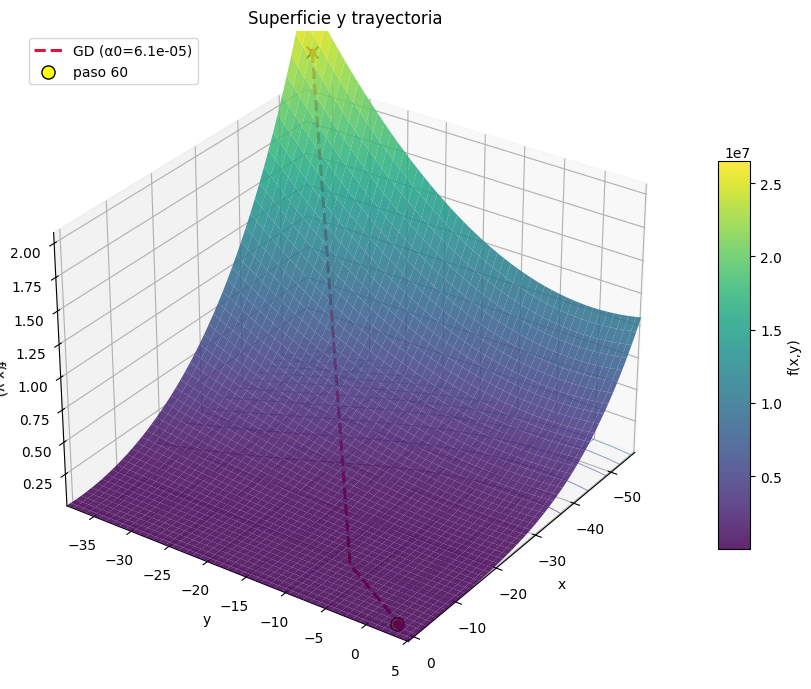

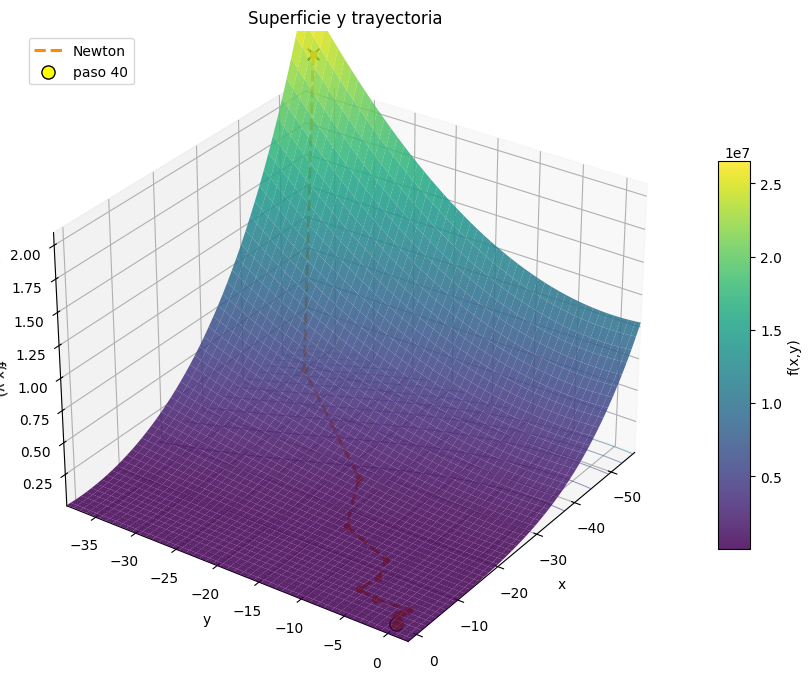

In [10]:

with open("./data/results_N400_summary.json") as fjson:
    payload = json.load(fjson)

rec = payload["results"][0]

# Cargar paths/alphas/lambdas desde el .npz referenciado
paths_data = load_paths_for_case(rec, data_dir="./data")
path_gd = paths_data["GD"]
path_nd = paths_data["Newton"]

if path_gd is not None:
    path_gd = path_gd[::2]
if path_nd is not None:
    path_nd = path_nd[::1]

# alpha0 para la etiqueta: viene del .npz
a0 = None
if isinstance(paths_data.get("GD_alphas"), np.ndarray) and paths_data["GD_alphas"].size > 0:
    a0 = float(paths_data["GD_alphas"][0])
label_gd = f"GD (α0={a0:.3g})" if a0 is not None else "GD"

if path_gd is not None and len(path_gd) > 0:
    fig, ax = plot_path_fxy(path_gd,
                  kmax=60,
                  highlight_k=60,
                  show_tail=250,
                  marker_every=2,
                  color='crimson',
                  label=label_gd,
                  save_path="./figs/gd_trayectoria_3d.png",
                  dpi=300,
                  show=True)


if path_nd is not None and len(path_nd) > 0:
    plot_path_fxy(path_nd,
                  kmax=40,
                  highlight_k=40,
                  show_tail=200,
                  marker_every=1,
                  color='darkorange',
                  label='Newton',
                  save_path="./figs/newton_trayectoria_3d.png",
                  dpi=300,
                  show=True)


El algoritmo de Armijo es una regla de búsqueda lineal que escoge el paso más pequeño que aún produce una reducción significativa en la función objetivo; parte de una longitud tentativa y la reduce geométricamente hasta satisfacer la condición de Armijo, asegurando así que cada iteración disminuya el valor de la función sin entrar en cálculos de derivadas secundarias.